In [1]:
pip install tensorflow opencv-python pycocotools

  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/4a/9b/8f89d36e4a23166ccabe5c9fed00baffaa6a67609add316fc1334bbf4016/pycocotools-2.0.8-cp312-cp312-win_amd64.whl.metadata
   ---------------------------------------- 0.0/83.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/83.3 kB ? eta -:--:--
   --------- ------------------------------ 20.5/83.3 kB ? eta -:--:--
   -------------- ------------------------- 30.7/83.3 kB 660.6 kB/s eta 0:00:01
   -------------- ------------------------- 30.7/83.3 kB 660.6 kB/s eta 0:00:01
   ------------------- -------------------- 41.0/83.3 kB 217.9 kB/s eta 0:00:01
   ------------------- -------------------- 41.0/83.3 kB 217.9 kB/s eta 0:00:01
   ------------------- -------------------- 41.0/83.3 kB 217.9 kB/s eta 0:00:01
   ---------------------------------------- 83.3/83.3 kB 259.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


DATASET

In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import os
from pycocotools.coco import COCO

# Assuming you have defined CocoDataset class to load annotations
class CocoDataset:
    def __init__(self, images_dir, annotation_file):
        self.images_dir = images_dir
        self.annotation_file = annotation_file
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

    def load_image(self, image_id):
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224))  # Resize image if needed
        image = image / 255.0  # Normalize to [0, 1]
        return image

    def load_annotations(self, image_id):
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        labels = np.zeros((self.coco.cats.__len__()))
        for ann in anns:
            labels[ann['category_id'] - 1] = 1.0  # One-hot encode labels
        return labels

# Example initialization of datasets
train_dataset = CocoDataset(
    images_dir='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/train',
    annotation_file='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/train/_annotations.coco.json'
)

valid_dataset = CocoDataset(
    images_dir='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/valid',
    annotation_file='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/valid/_annotations.coco.json'
)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [16]:
def generate_y_true(dataset):
    y_true = []
    for image_id in dataset.image_ids:
        labels = dataset.load_annotations(image_id)
        y_true.append(labels)
    return np.array(y_true)

y_true_single_train = generate_y_true(train_dataset)
y_true_single_valid = generate_y_true(valid_dataset)

In [17]:
# Example of generating y_score_single (dummy values)
y_score_single_valid = np.random.rand(len(valid_dataset.image_ids), len(train_dataset.coco.cats))

In [12]:
class_labels = [cat['name'] for cat in train_dataset.coco.loadCats(train_dataset.coco.getCatIds())]

MODEL

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_dataset.coco.cats.__len__(), activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=0.01)  # Adjust learning_rate here
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=1,
    batch_size=32
)

# Save the model
model.save('chicken_detection_model_resnet50.h5')


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 528s 7s/step - accuracy: 0.9665 - loss: 0.0575 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


PREDICTION

LOAD MODEL

In [13]:
from tensorflow.keras.preprocessing import image

def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

def predict(image_path, model, class_labels):
    # Preprocess the image
    processed_image = preprocess_image(image_path)

    # Make the prediction
    prediction = model.predict(processed_image)

    # Decode the results
    predicted_class_indices = np.where(prediction > 0.5)[1]
    predicted_classes = [class_labels[idx] for idx in predicted_class_indices]

    return predicted_classes, prediction

# Example usage
image_path = 'C:/Users/maryc/Documents/chickendetection code/Opal.jpg'  # Replace with the path to your image
class_labels = [cat['name'] for cat in train_dataset.coco.cats.values()]  # Get class labels from the dataset
predicted_classes, prediction = predict(image_path, model, class_labels)

print("Predicted Classes:", predicted_classes)
print("Prediction Scores:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Predicted Classes: ['sick-healthy']
Prediction Scores: [[1. 0.]]


GRAPHS

In [15]:
pip install matplotlib scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/57/ed/f607ebf69f87bcce2e3fa329bd78da8cafd3d51190a19d58012d2d7f2252/scikit_learn-1.5.0-cp312-cp312-win_amd64.whl.metadata
  Using cached scikit_learn-1.5.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.0-cp312-cp312-win_amd64.whl (10.9 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import numpy as np
import cv2
import os
from pycocotools.coco import COCO

# Assuming you have defined CocoDataset class to load annotations
class CocoDataset:
    def __init__(self, images_dir, annotation_file):
        self.images_dir = images_dir
        self.annotation_file = annotation_file
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

    def load_image(self, image_id):
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224))  # Resize image if needed
        image = image / 255.0  # Normalize to [0, 1]
        return image

    def load_annotations(self, image_id):
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        labels = np.zeros((self.coco.cats.__len__()))
        for ann in anns:
            labels[ann['category_id'] - 1] = 1.0  # One-hot encode labels
        return labels

# Example initialization of datasets
train_dataset = CocoDataset(
    images_dir='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/train',
    annotation_file='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/train/_annotations.coco.json'
)

valid_dataset = CocoDataset(
    images_dir='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/valid',
    annotation_file='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/valid/_annotations.coco.json'
)

# Load training images and labels
x_train_images = []
y_train_labels = []

for image_id in train_dataset.image_ids:
    image = train_dataset.load_image(image_id)
    annotations = train_dataset.load_annotations(image_id)
    x_train_images.append(image)
    y_train_labels.append(annotations)

# Convert lists to numpy arrays for compatibility with TensorFlow/Keras
x_train_images = np.array(x_train_images)
y_train_labels = np.array(y_train_labels)

# Example of shapes
print(f"x_train_images.shape: {x_train_images.shape}")  # Should be (num_samples, height, width, channels)
print(f"y_train_labels.shape: {y_train_labels.shape}")  # Should be (num_samples, num_classes), where num_classes is the number of categories



loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
x_train_images.shape: (2129, 224, 224, 3)
y_train_labels.shape: (2129, 2)


In [3]:
import numpy as np
import cv2
import os
from pycocotools.coco import COCO
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Assuming you have defined CocoDataset class to load annotations
class CocoDataset:
    def __init__(self, images_dir, annotation_file):
        self.images_dir = images_dir
        self.annotation_file = annotation_file
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.class_labels = [cat['name'] for cat in self.coco.cats.values()]
        self.label_encoder = LabelEncoder()
        self.one_hot_encoder = OneHotEncoder()

        # Fit label encoder and one-hot encoder
        self.label_encoder.fit(self.class_labels)
        self.one_hot_encoder.fit(self.label_encoder.transform(self.class_labels).reshape(-1, 1))

    def load_image(self, image_id):
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224))  # Resize image if needed
        image = image / 255.0  # Normalize to [0, 1]
        return image

    def load_annotations(self, image_id):
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        labels = np.zeros(len(self.class_labels))
        for ann in anns:
            labels[self.label_encoder.transform([self.coco.loadCats(ann['category_id'])[0]['name']])[0]] = 1.0  # One-hot encode labels
        return labels

# Example initialization of datasets
train_dataset = CocoDataset(
    images_dir='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/train',
    annotation_file='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/train/_annotations.coco.json'
)

valid_dataset = CocoDataset(
    images_dir='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/valid',
    annotation_file='C:/Users/maryc/Downloads/sick and healthy chicken.v1i.coco/valid/_annotations.coco.json'
)

# Load training images and labels
x_train_images = []
y_train_labels = []

for image_id in train_dataset.image_ids:
    image = train_dataset.load_image(image_id)
    annotations = train_dataset.load_annotations(image_id)
    x_train_images.append(image)
    y_train_labels.append(annotations)

# Convert lists to numpy arrays for compatibility with TensorFlow/Keras
x_train_images = np.array(x_train_images)
y_train_labels = np.array(y_train_labels)

# Example of shapes
print(f"x_train_images.shape: {x_train_images.shape}")  # Should be (num_samples, height, width, channels)
print(f"y_train_labels.shape: {y_train_labels.shape}")  # Should be (num_samples, num_classes), where num_classes is the number of categories

# Function to prepare y_true_single, y_score_single, and class_labels
def prepare_evaluation_data(images, labels, dataset):
    y_true_single = []
    y_score_single = []
    
    for i in range(len(images)):
        image = np.expand_dims(images[i], axis=0)
        y_true_single.append(labels[i])
        y_score_single.append(model.predict(image)[0])  # Assuming `model` is loaded and defined elsewhere
    
    y_true_single = np.array(y_true_single)
    y_score_single = np.array(y_score_single)
    class_labels = dataset.class_labels
    
    return y_true_single, y_score_single, class_labels

# Example usage to generate y_true_single, y_score_single, and class_labels
y_true_single, y_score_single, class_labels = prepare_evaluation_data(x_train_images, y_train_labels, train_dataset)

# Example of shapes after preparation
print(f"y_true_single.shape: {y_true_single.shape}")  # Should be (num_samples, num_classes)
print(f"y_score_single.shape: {y_score_single.shape}")  # Should be (num_samples, num_classes)

# Example usage to plot ROC curve, Precision-Recall curve, etc.
# Implement your plotting functions for ROC curve, Precision-Recall curve, etc. here


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
x_train_images.shape: (2129, 224, 224, 3)
y_train_labels.shape: (2129, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━

c:\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


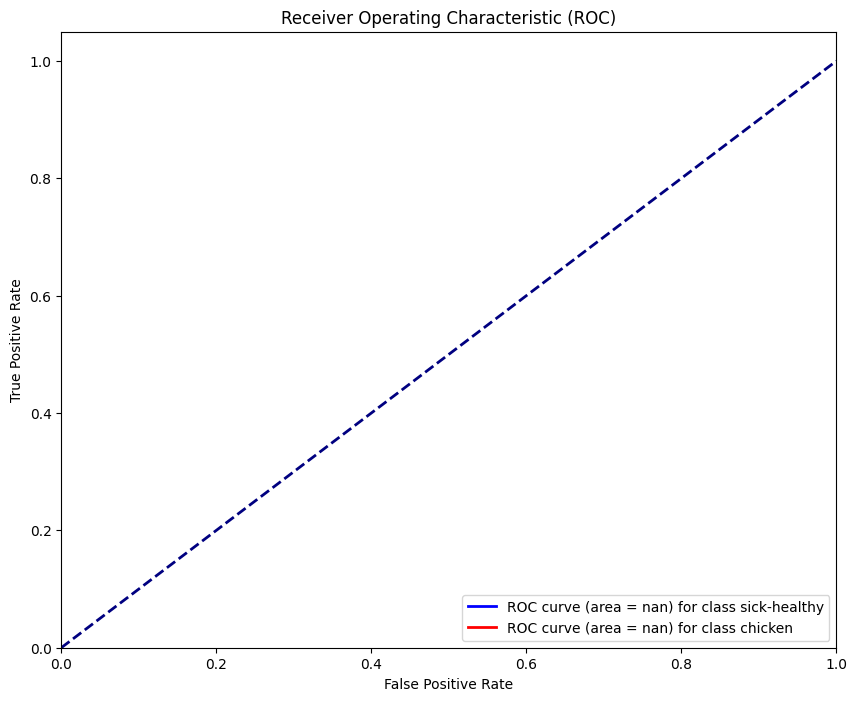

c:\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


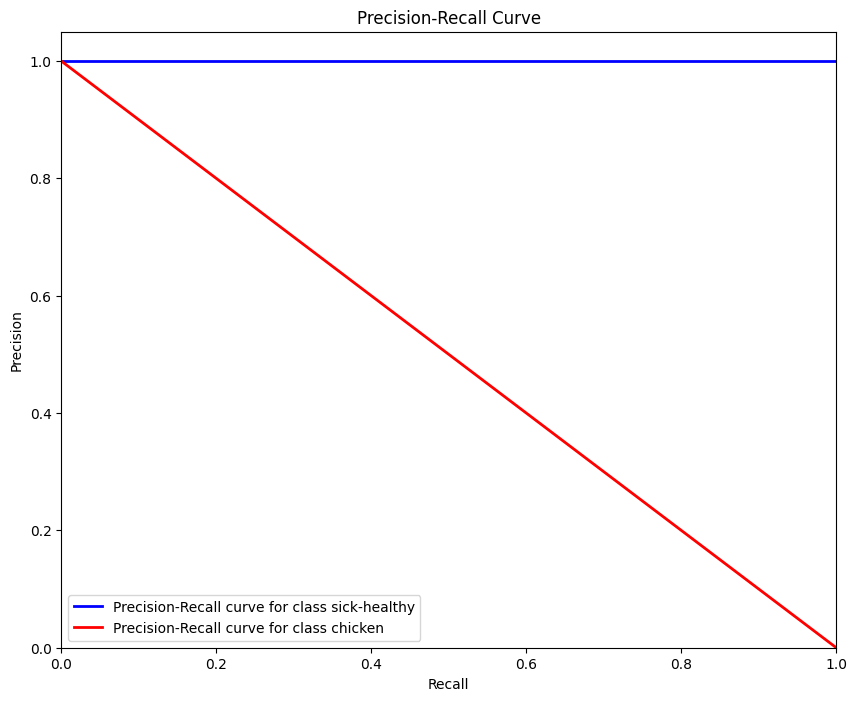

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

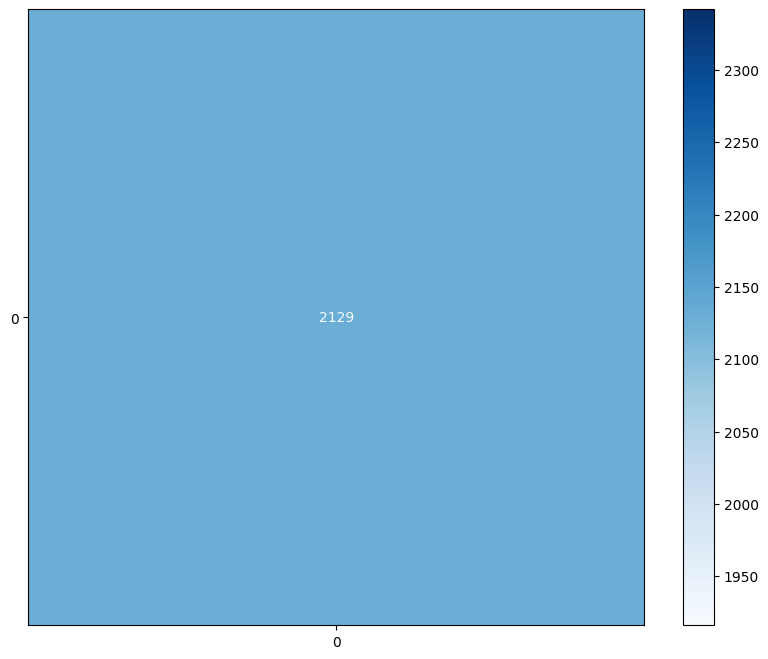

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Assuming you have defined CocoDataset class to load annotations and preprocess images (from previous examples)
# Assuming you have loaded the dataset into x_train_images, y_train_labels

# Load your saved model
model_path = 'C:/Users/maryc/Documents/chickendetection code/chicken_detection_model_resnet50.h5'
model = load_model(model_path)

# Function to prepare y_true_single, y_score_single, and class_labels
def prepare_evaluation_data(images, labels, dataset):
    y_true_single = []
    y_score_single = []
    
    for i in range(len(images)):
        image = np.expand_dims(images[i], axis=0)
        y_true_single.append(labels[i])
        y_score_single.append(model.predict(image)[0])  # Predict using the loaded model
    
    y_true_single = np.array(y_true_single)
    y_score_single = np.array(y_score_single)
    class_labels = dataset.class_labels
    
    return y_true_single, y_score_single, class_labels

# Example usage to generate y_true_single, y_score_single, and class_labels
y_true_single, y_score_single, class_labels = prepare_evaluation_data(x_train_images, y_train_labels, train_dataset)

# Plot ROC curves for each class
def plot_roc_curve(y_true, y_score, class_labels):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']  # Define colors for different classes
    
    for i, color in zip(range(len(class_labels)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], class_labels[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curves for each class
def plot_precision_recall_curve(y_true, y_score, class_labels):
    # Compute Precision-Recall curve and area for each class
    precision = dict()
    recall = dict()
    
    for i in range(len(class_labels)):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])

    # Plot Precision-Recall curves for each class
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']  # Define colors for different classes
    
    for i, color in zip(range(len(class_labels)), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='Precision-Recall curve for class %s' % (class_labels[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Example usage of plotting functions
# Plot ROC curves for each class
plot_roc_curve(y_true_single, y_score_single, class_labels)

# Plot Precision-Recall curves for each class
plot_precision_recall_curve(y_true_single, y_score_single, class_labels)

# Plot confusion matrix
y_pred = np.argmax(y_score_single, axis=1)
plot_confusion_matrix(np.argmax(y_true_single, axis=1), y_pred, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━

c:\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


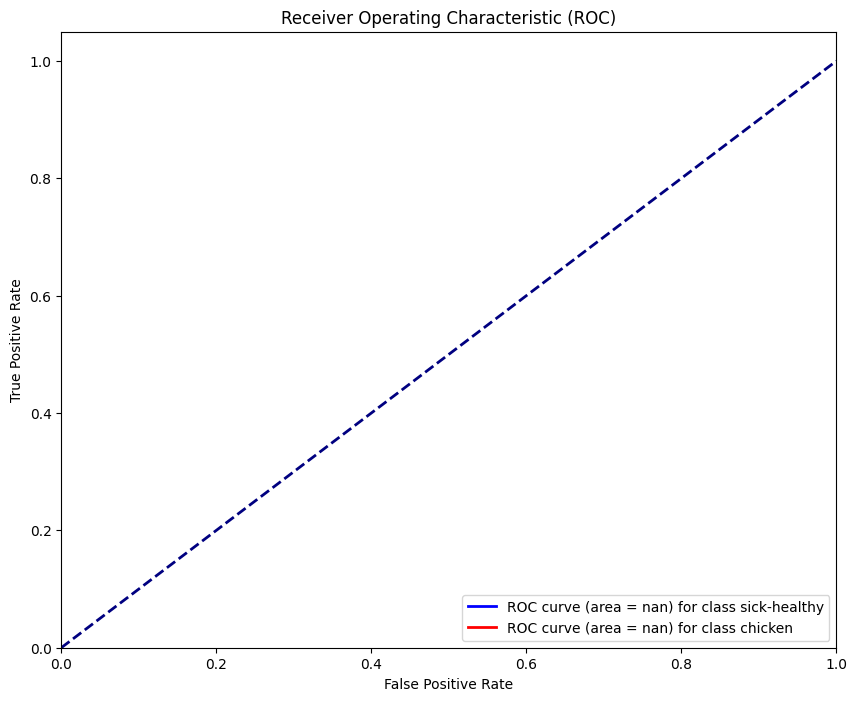

c:\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


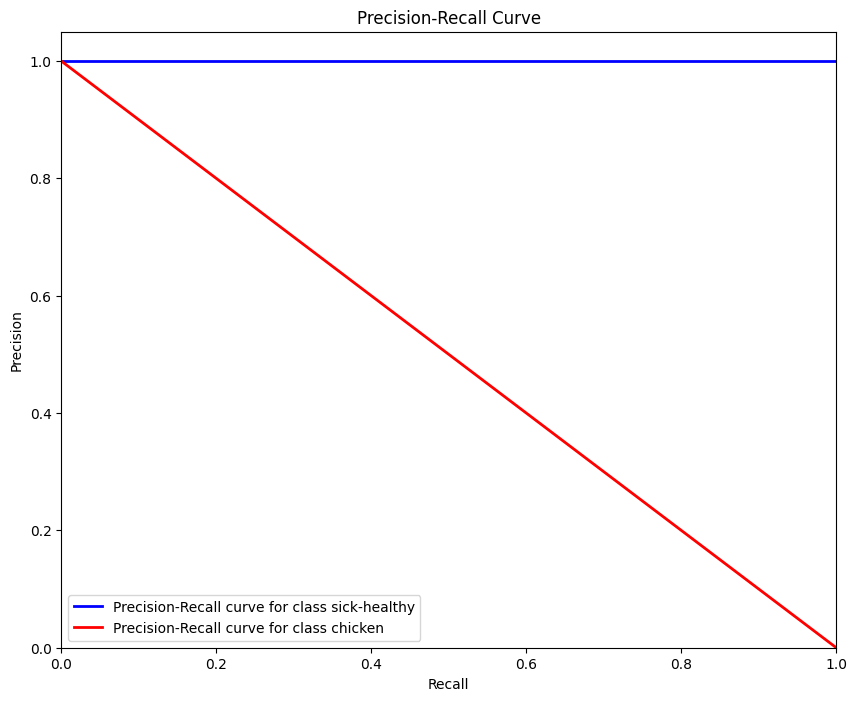

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

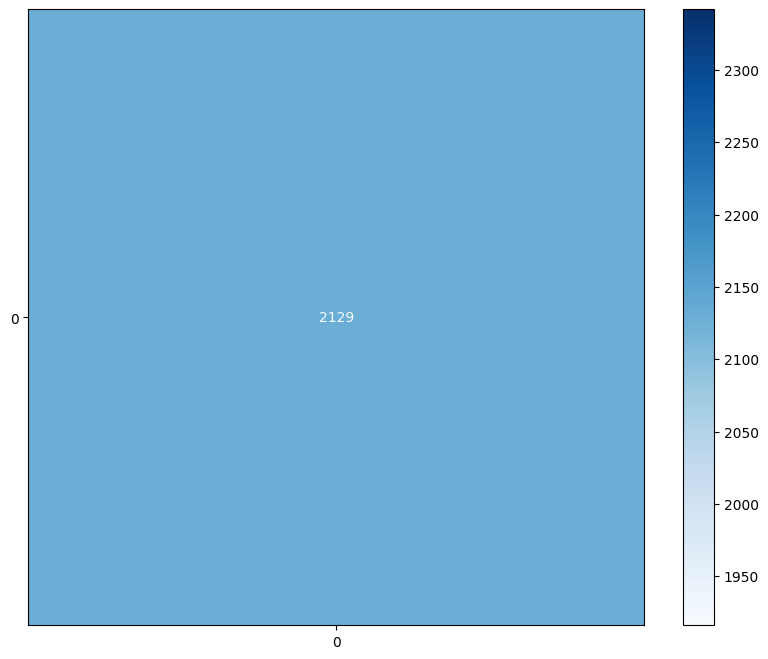

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
from sklearn.calibration import calibration_curve
from tensorflow.keras.models import load_model

# Assuming you have defined CocoDataset class to load annotations and preprocess images (from previous examples)
# Assuming you have loaded the dataset into x_train_images, y_train_labels

# Load your saved model
model_path = 'C:/Users/maryc/Documents/chickendetection code/chicken_detection_model_resnet50.h5'
model = load_model(model_path)

# Function to prepare y_true_single, y_score_single, and class_labels
def prepare_evaluation_data(images, labels, dataset):
    y_true_single = []
    y_score_single = []
    
    for i in range(len(images)):
        image = np.expand_dims(images[i], axis=0)
        y_true_single.append(labels[i])
        y_score_single.append(model.predict(image)[0])  # Predict using the loaded model
    
    y_true_single = np.array(y_true_single)
    y_score_single = np.array(y_score_single)
    class_labels = dataset.class_labels
    
    return y_true_single, y_score_single, class_labels

# Example usage to generate y_true_single, y_score_single, and class_labels
y_true_single, y_score_single, class_labels = prepare_evaluation_data(x_train_images, y_train_labels, train_dataset)

# Plot ROC curves for each class
def plot_roc_curve(y_true, y_score, class_labels):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']  # Define colors for different classes
    
    for i, color in zip(range(len(class_labels)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], class_labels[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curves for each class
def plot_precision_recall_curve(y_true, y_score, class_labels):
    # Compute Precision-Recall curve and area for each class
    precision = dict()
    recall = dict()
    
    for i in range(len(class_labels)):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])

    # Plot Precision-Recall curves for each class
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']  # Define colors for different classes
    
    for i, color in zip(range(len(class_labels)), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='Precision-Recall curve for class %s' % (class_labels[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Classification report
def plot_classification_report(y_true, y_pred, class_labels):
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    plt.figure(figsize=(10, 8))
    plt.imshow([[report[key][metric] for key in class_labels] for metric in ['precision', 'recall', 'f1-score']], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Classification Report')
    plt.colorbar()
    x_tick_marks = np.arange(len(class_labels))
    y_tick_marks = np.arange(3)
    plt.xticks(x_tick_marks, class_labels, rotation=45)
    plt.yticks(y_tick_marks, ['precision', 'recall', 'f1-score'])
    plt.tight_layout()
    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.show()

# Precision-Recall threshold curve
def plot_precision_recall_threshold_curve(y_true, y_score, class_labels):
    plt.figure(figsize=(10, 8))
    precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_score.ravel())
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend()
    plt.title('Precision-Recall Threshold Curve')
    plt.ylim([0, 1])
    plt.show()

# Calibration curve
def plot_calibration_curve(y_true, y_score, class_labels):
    plt.figure(figsize=(10, 8))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true.ravel(), y_score.ravel(), n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Model')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.ylabel('Fraction of positives')
    plt.xlabel('Mean predicted value')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

# Cumulative gain chart
def plot_cumulative_gain_chart(y_true, y_score, class_labels):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_labels)):
        sorted_indices = np.argsort(y_score[:, i])[::-1]
        cumulative_gains = np.cumsum(y_true[sorted_indices, i]) / np.sum(y_true[:, i])
        plt.plot(np.linspace(0, 1, len(cumulative_gains)), cumulative_gains, label=f'{class_labels[i]}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('Percentage of sample')
    plt.ylabel('Cumulative gain')
    plt.title('Cumulative Gain Chart')
    plt.legend(loc="lower right")
    plt.show()

# Example usage of plotting functions
# Plot ROC curves for each class
plot_roc_curve(y_true_single, y_score_single, class_labels)

# Plot Precision-Recall curves for each class
plot_precision_recall_curve(y_true_single, y_score_single, class_labels)

# Plot confusion matrix
y_pred = np.argmax(y_score_single, axis=1)
plot_confusion_matrix(np.argmax(y_true_single, axis=1), y_pred, class_labels)

# Plot classification report
plot_classification_report(np.argmax(y_true_single, axis=1), y_pred, class_labels)

# Plot Precision-Recall threshold curve
plot_precision_recall_threshold_curve(y_true_single, y_score_single, class_labels)

# Plot Calibration curve
plot_calibration_curve(y_true_single, y_score_single, class_labels)

# Plot Cumulative gain chart
plot_cumulative_gain_chart(y_true_single, y_score_single, class_labels)


INTRUDER DETETCTION

C:\Users\maryc\AppData\Local\Temp\ipykernel_868\2685633179.py:105: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, frames=None, blit=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


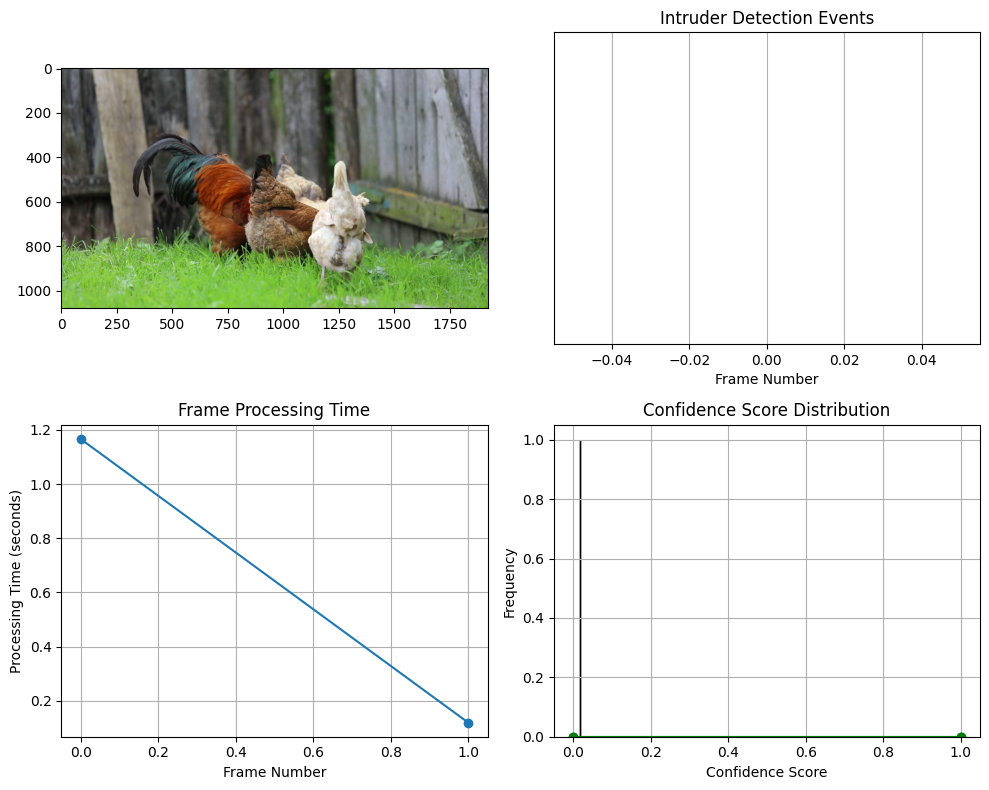

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2 model for object detection
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1000, activation='softmax')(x)  # Output layer for ImageNet classes
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize variables for metrics
processing_times = []
bird_counts = []
intruder_detected = []
confidence_scores = []
chickens_detected = []  # List to store number of chickens detected per frame

# Video file path
video_path = '856986-hd_1920_1080_25fps.mp4'  # Replace with your video file path

# Open video capture
cap = cv2.VideoCapture(video_path)

# Setup matplotlib figure and axis for video feed
fig, ((ax_video1, ax_video2), (ax_graphs1, ax_graphs2)) = plt.subplots(2, 2, figsize=(10, 8))

# Initialize video display
ret, frame = cap.read()
if ret:
    im = ax_video1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

frame_number = 0

def update(frame):
    global frame_number

    ret, frame = cap.read()
    if not ret:
        return im,

    frame_number += 1

    # Preprocess frame for MobileNetV2
    input_data = cv2.resize(frame, (224, 224))
    input_data = np.expand_dims(input_data, axis=0)
    input_data = preprocess_input(input_data)

    # Perform inference
    start_time = cv2.getTickCount()
    predictions = model.predict(input_data)
    end_time = cv2.getTickCount()
    processing_time = (end_time - start_time) / cv2.getTickFrequency()
    processing_times.append(processing_time)

    # Example logic to count birds and detect intruders
    # Replace this with your actual detection logic
    bird_count = 0
    intruder_present = False

    # Track bird counts
    bird_counts.append(bird_count)

    # Example logic to count chickens (replace with actual detection logic)
    # For demonstration purposes, assume chickens are class 15 in ImageNet classes
    # Adjust this based on the actual class index for chickens in your model
    class_index_chicken = 15  # Example: class 15 for chickens in ImageNet
    if predictions[0][class_index_chicken] > 0.5:  # Check if confidence for chickens is above threshold
        num_chickens = 1  # For simplicity, assume only one chicken is detected per frame
    else:
        num_chickens = 0

    chickens_detected.append(num_chickens)

    # Check if intruder is detected (example logic)
    if bird_count > 0:  # Replace with actual intruder detection logic
        intruder_present = True

    # Record intruder detection events
    if intruder_present:
        intruder_detected.append(frame_number)

    # Record confidence score distribution
    confidence = np.max(predictions)
    confidence_scores.append(confidence)

    # Display results on video feed
    ax_video1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    return im,

# Animation function to update video feed
ani = FuncAnimation(fig, update, frames=None, blit=True)

# Plot 4 graphs
ax_graphs1.plot(range(len(processing_times)), processing_times, marker='o')
ax_graphs1.set_xlabel('Frame Number')
ax_graphs1.set_ylabel('Processing Time (seconds)')
ax_graphs1.set_title('Frame Processing Time')
ax_graphs1.grid(True)

ax_graphs2.plot(range(len(bird_counts)), bird_counts, marker='o')
ax_graphs2.set_xlabel('Frame Number')
ax_graphs2.set_ylabel('Bird Count')
ax_graphs2.set_title('Bird Count Over Time')
ax_graphs2.grid(True)

# Plot intruder detection events
ax_video2.plot(intruder_detected, np.ones_like(intruder_detected), 'ro')
ax_video2.set_xlabel('Frame Number')
ax_video2.set_title('Intruder Detection Events')
ax_video2.set_yticks([])
ax_video2.grid(True)

# Plot number of chickens detected
ax_graphs2.plot(range(len(chickens_detected)), chickens_detected, marker='o', color='green')
ax_graphs2.set_xlabel('Frame Number')
ax_graphs2.set_ylabel('Number of Chickens')
ax_graphs2.set_title('Number of Chickens Detected')
ax_graphs2.grid(True)

# Plot confidence score distribution
ax_graphs2.hist(confidence_scores, bins=20, edgecolor='black')
ax_graphs2.set_xlabel('Confidence Score')
ax_graphs2.set_ylabel('Frequency')
ax_graphs2.set_title('Confidence Score Distribution')
ax_graphs2.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Release video capture
cap.release()
